# NOTEBOOK PARA A VISUALIZAÇÃO DOS RESULTADOS DA MODELAGEM

- O critério de seleção dos melhores modelos é o menor valor do RMSE na validação

## IMPORTANDO OS MÓDULOS

In [17]:
#warnings
import warnings
#time
import time
# data manipulation
import json
import numpy as np
import pandas as pd

# geospatial viz
import folium
from folium import Choropleth, Circle, Marker, Icon, Popup, FeatureGroup
from folium.plugins import HeatMap, FastMarkerCluster, MiniMap
from folium.features import GeoJsonPopup, GeoJsonTooltip

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches

#geospatial analysis
#import ee
import collections
import geopandas as gpd


#date manipulation
from datetime import timedelta
from datetime import datetime


#windows folder manipulation
import os

#statistics
import statistics
from statistics import mean
import scipy
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from scipy.stats import zscore

#regressions, metrics and models optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split #split database in training and testing data
from sklearn.ensemble import RandomForestRegressor #randomforest regression
from sklearn.linear_model import LinearRegression, Lasso #linear regression or multiple linear regression
from sklearn.neural_network import MLPRegressor #neural network
from sklearn.svm import SVR #svm regression
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, make_scorer
from xgboost import XGBRegressor

#dataframe storage
import pickle

## CLASSE PARA VISUALIZAÇÃO

In [18]:
warnings.simplefilter('ignore')

class Model():
    '''
        Model class encapsulate all methods to originate modelling results.
        
        Parameters:
        ------------
        X: pd.dataframe
            dataframe with independent (univariate) or independents (multivariate) variables
        y: pd.series
            dependent variable
        gv: bool
            set grid search to True or False
        model: Sklearn.model
            model desired | default = LinearRegression()
        wqp_unit: str
            enter wqp unit ex:mg/L
        mult_v: bool
            define if model is multivariate (more than one independent variable) or not. True or False
        m_type: str
            define the type of transformation to be applied in the data | default: linear (data as it is)
            Other types: 'poly', 'exp', 'log', 'standard_scaler', 'max_min'
        verbose: bool
            decide between printing processing results or not | default = True
        '''
    
    def __init__(self, X, y, gv=True, model=LinearRegression(), wqp_unit={}, mult_v = True, m_type = 'linear', verbose = True):
        self.X_name = ", ".join(list(X.columns))
        self.y_name = y.name
        self.gv = gv
        self.y = y
        self.model = model
        self.wqp_unit = wqp_unit
        self.result_dict = {}
        self.type = m_type
        self.mult_v = mult_v
        self.verbose = verbose
        if self.mult_v == False:
            self.X = np.array(X).reshape(-1,1)
            
        else:
            self.X = X

    def r2_func(self, y_obs, y_pred):
        ''' R2 metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        r2: float
            r2 metric
        '''
        
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        y_hat = (1/len(y_obs))*sum(y_obs)
        TSS = sum((y_obs-y_hat)**2)
        RSS = sum((y_obs - y_pred)**2)
        r2 = round(1 - RSS/TSS,2)
        return r2

    def adj_r2_func(self, y_obs, y_pred):
        ''' Adjusted R2 metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        adj_r2: float
            adj_r2 metric
        '''
        if self.type == 'exp' and self.mult_v == False:
            adj_r2 = self.r2_func(y_obs, y_pred)
        else:
            n = y_obs.shape[0]
            p = self.X.shape[1]
            adj_r2 = round(1 - ((1 - self.r2_func(y_obs, y_pred)) * (n - 1))/(n-p-1), 2)
        return adj_r2
    
    def mae_func(self, y_obs, y_pred):
        ''' MAE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        MAE: float
            MAE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        mae = round((np.sum(abs(y_obs - y_pred))/len(y_pred)), 2)
        return mae

    def mape_func(self, y_obs, y_pred):
        ''' MAPE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        MAPE: float
            MAPE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        mape = round((np.sum(abs((y_obs - y_pred)/y_obs))/len(y_pred)), 2)
        return mape*100

    def rmse_func(self, y_obs, y_pred):
        ''' RMSE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        RMSE: float
            RMSE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        rmse = round((sum((np.subtract(y_obs, y_pred))**2)/len(y_obs))**0.5,2)
        return rmse
    
    def nrmse_func(self, y_obs, y_pred):
        ''' NRMSE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        NRMSE: float
            NRMSE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        rmse = (sum((np.subtract(y_obs, y_pred))**2)/len(y_obs))**0.5
        nrmse = round(rmse/mean(y_obs),2)
        return nrmse*100

    def scoring_func(self):
        ''' Scorer method uses sklearn make scorer method and allow
        to create the metric methods listed above.
        Parameters
        ------------
        self: instace
        Returns:
        ------------
        scoring: dict
            scoring dictionary with make_scorer as methods
        '''
        r2_score_t = make_scorer(self.r2_func, greater_is_better=True)
        adj_r2_score_t = make_scorer(self.adj_r2_func, greater_is_better=True)
        rmse_score = make_scorer(self.rmse_func, greater_is_better=False)
        nrmse_score = make_scorer(self.nrmse_func, greater_is_better=False)
        mae_score = make_scorer(self.mae_func, greater_is_better=False)
        mape_score = make_scorer(self.mape_func, greater_is_better=False)
        scoring = {'R²': r2_score_t, 
                   'Adjusted R²': adj_r2_score_t, 
                    'MAE': mae_score, 
                    'MAPE (%)': mape_score, 
                    'RMSE': rmse_score, 
                    'NRMSE (%)': nrmse_score}
        return scoring

    def boxplot_score(self, df, scores, palette):
        '''
        Boxplot plots method.
        Parameters
        -----------
        df: dataframe
            dataframe with metrics
        scores: list
            scores names
        palette: list
            colors to plot
        Returns
        ----------
        fig: image
            matplotlib plot
        '''
        cm = 1/2.54
        sns.set_context('paper')
        fig, axs = plt.subplots(ncols = 2, nrows=3, figsize=(30*cm, 30*cm))
        row, col = 0, 0
        for letter, score in zip(['a', 'b', 'c', 'd', 'e', 'f'], scores):
            e = sns.boxplot(ax = axs[row, col], data=df.melt(value_vars=["train_"+score, "test_"+score], value_name='score'), y='score', x='variable', palette=palette)
            e.set_xticklabels(['Train' + '\nn={:.0f}'.format(df["train_"+score].shape[0]) \
                               + '\nMedia: {:.2f}'.format(np.mean(df["train_"+score])) \
                               +'\nDesv. P.: {:.2f}'.format(np.std(df["train_"+score])),                                                     
                               'Test' + '\nn={:.0f}'.format(df["test_"+score].shape[0]) \
                               +'\nMedia: {:.2f}'.format(np.mean(df["test_"+score])) \
                               +'\nDesv. P.: {:.2f}'.format(np.std(df["test_"+score]))])
            if score.endswith("R²") or score.endswith("(%)"):
                e.set_ylabel(score)
            else:
                e.set_ylabel(score + ' ' + self.wqp_unit)
    
            e.set_xlabel('')
            e.spines['right'].set_visible(False)
            e.spines['left'].set_visible(True)
            e.spines['top'].set_visible(False)
            e.spines['bottom'].set_visible(True)
            e.yaxis.grid(color='gray', linestyle='dashed')
            e.yaxis.grid(color='gray', linestyle='dashed')
            e.set_title(letter)
            e.axhline(y = self.dummy_results.get(f"dummy_{score}"), c= 'red', linestyle='--')
            col +=1
    
            if col == 2:
                col = 0
                row+=1
                
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
        
        return plt.show()
    
    
    def validation_plots(self, residuals):
        '''
        Plots to be presented in validation step.
        Parameters
        -----------
        residuals: np.array
            array with residuals
        Returns
        ----------
        fig: image
            matplotlib plot
        '''
    
        def res_hist_plot(self, residuals):
            array = residuals
            #fig, ax = plt.subplots(figsize=(10*cm ,10*cm))
            g = sns.histplot(ax = axs[0,0], x=array)
            g.set_xlabel('Resíduos')
            g.set_ylabel('Frequência')
            g.set_title('a')
            #plt.show()
            return g
            
        def res_lineplot(self, residuals):
            
            g=sns.scatterplot(x = residuals.index, y = residuals, color='b', marker='.', ax = axs[0,1])
            g.axhline(y=0, c= 'red', linestyle='--')
            g.spines['right'].set_visible(False)
            g.spines['left'].set_visible(True)
            g.spines['top'].set_visible(False)
            g.spines['bottom'].set_visible(True)
            g.yaxis.grid(color='gray', linestyle='dashed')
            g.set_ylabel('∆ '+ g.get_ylabel())
            g.set_xlabel('Índice')
            g.set_title('b')
            g.set_xlim(g.get_xticks()[0]-0.5, g.get_xticks()[-1]+0.5)
            g.set_ylim(g.get_yticks()[0], g.get_yticks()[0] *-1)
            return g  
            
        def res_qq_plot(self, residuals):
            array = residuals
            array_norm = (array - array.mean()) / array.std()
            array_norm=array_norm.sort_values(ascending=True)
            norm_dist = np.random.normal(loc=0, scale=1, size=len(array_norm))
            norm_dist.sort()
            ax = sns.scatterplot(x = norm_dist, y = array_norm, marker='.', color='b', ax = axs[1,0])
            ax.plot(norm_dist, norm_dist, c='red')
            lims = [norm_dist.min(), norm_dist.max()]
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            ax.set_xlabel("Quantis da Distribuição Normal")
            ax.set_ylabel("Quantis Observados")
            ax.set_aspect('equal')
            ax.set_title('c')
            return ax
            
        def pred_obs_scatter(self):
            h = sns.scatterplot(x = self.y_test, y=self.y_pred, color='darkgrey', ax = axs[1,1])      
            h.spines['right'].set_visible(True)
            h.spines['left'].set_visible(True)
            h.spines['top'].set_visible(True)
            h.spines['bottom'].set_visible(True)
            h.set_ylabel('Valores estimados de '+ h.get_xlabel())
            h.set_xlabel('Valores observados de '+ h.get_xlabel())
            h.set_title('Correlação entre valores estimados e observados')
            lims = [
                np.min([h.get_xlim(), h.get_ylim()]),  # min of both axes
                np.max([h.get_xlim(), h.get_ylim()]),  # max of both axes
            ]
            if lims[0]<0:
                lims[0]=0
            else:
                pass
            # now plot both limits against eachother
            h.plot(lims, lims, '--', alpha=0.5, zorder=0, color='gray')
            h.text(0.93, 0.9,'1:1', fontdict={'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '45'}, transform=h.transAxes)
            h.set_title('d')
            h.set_xticks(h.get_yticks())
            h.set_xlim(lims)
            h.set_ylim(lims)
            h.set_aspect('equal')
            h.text(0.02,
                   0.98,
                   "n = {} | R²: {:.2f} | AdjR²: {:.2f}".format(self.y_test.shape[0], self.val_r2, self.val_adj_r2),
                   fontdict={'ha': 'left', 'va': 'top', 'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '0'},
                   transform=h.transAxes)
            
            h.text(0.99,
                   0.01,
                   "MAE: " + "{:.1f} {} |".format(self.val_mae, self.wqp_unit) \
                   + " MAPE: " + "{:.0f} %".format(self.val_mape) \
                   + "\nRMSE: " + "{:.1f} {} |".format(self.val_rmse, self.wqp_unit) \
                   + " nRMSE: " + "{:.0f} %".format(self.val_nrmse),
                   fontdict={'ha': 'right', 'va': 'bottom', 'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '0'},
                   transform=h.transAxes)
            return h
        
        cm = 1/2.54
        fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(30*cm, 30*cm))
        res_hist_plot(self, residuals)
        res_lineplot(self, residuals)
        res_qq_plot(self, residuals)
        pred_obs_scatter(self)
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
        return plt.show()
            
    def train_test_split_data(self, rs = None):
        self.test_rs = rs
        if self.type == 'linear':
            self.X, self.y = self.X, self.y
        elif self.type == 'poly':
            poly = PolynomialFeatures(degree = 2)
            self.X, self.y = poly.fit_transform(self.X), self.y
        elif self.type == 'exp':
            self.X, self.y = self.X, np.log(self.y)
        elif self.type == 'log':
            self.X, self.y = np.log(self.X), self.y
        elif self.type == 'standard_scaler':
            scaler = StandardScaler()
            self.X, self.y = scaler.fit_transform(self.X), self.y
        elif self.type == 'min_max':
            scaler = MinMaxScaler()
            self.X, self.y = scaler.fit_transform(self.X), self.y
        else:
            raise NameError('You probably forgot to enter a type. The types possible are: linear, poly, exp, poly, standard_scaler, min_max')
        
        if self.test_rs == None:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2)
            
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = self.test_rs)
        
    
    def grid_search(self, param_grid, scoring, refit, n_cv=5, r_t_c=True):
        '''
        Parameters
        ----------
        param_grid: dict
            Dictionary with model paramertes to be iterated
        scoring: dict
            All scoring methods to be used in model
        n_cv: int
            Number of Kfold in cross validation method
        refit: str
            Scoring method to return the best model
        r_t_c: bool
            Return train score
        '''
        if self.verbose == True:
            print("\n#--------------INICIANDO O GRID SEARCH CV------------#")
        else:
            pass
        
        self.scoring = scoring
        clf = GridSearchCV(self.model, 
                           param_grid = param_grid, 
                           scoring = self.scoring, 
                           cv = n_cv, 
                           refit = refit, 
                           return_train_score=r_t_c, 
                           verbose=0)
        clf.fit(self.X_train, self.y_train)
        temp_df=pd.DataFrame(clf.cv_results_, columns = sorted(clf.cv_results_.keys()))
        col = 'rank_test_' + refit
        self.params = temp_df.loc[temp_df[col].idxmin(), 'params']
        if self.verbose == True:
            print("\nO GridSearchCV encontrou os melhores hiperparâmetros \
                    para o modelo escolhido ({}), sendo eles: {}".format(self.model, self.params))
            print("\n#-----------FIM DO GRID SEARCH CV--------------#")
        else:
            pass
        del temp_df, clf
        
              
    def cv_model_results(self, n_cv=5, n_repeats=3, rs = None):
        self.cv_rs = rs
        if self.verbose == True:
            print("\n#--------------INICIANDO O CROSS VALIDATION PARA OS MELHORES HYPERPARAMETERS------------#")
        else:
            pass
        self.n_cv = n_cv
        self.n_repeats = n_repeats
        if self.cv_rs == None:
            cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats)
        else:
            cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats, random_state = self.cv_rs)
        self.len_train, self.len_test = [len(xs) for xs in list(cv.split(self.X_train))[0]]
        self.cv_results = cross_validate(self.model.set_params(**self.params), self.X_train, self.y_train, cv=cv,
                               scoring = self.scoring,
                               return_train_score = True,
                               verbose = 0,
                               return_estimator = True)
        dummy = DummyRegressor(strategy="mean").fit(self.X, self.y)
        dummy_pred = dummy.predict(self.X)
        self.dummy_results = {}
        self.dummy_results['dummy_R²'] = self.r2_func(self.y, dummy_pred)
        self.dummy_results['dummy_Adjusted R²'] = self.adj_r2_func(self.y, dummy_pred)
        self.dummy_results['dummy_MAE'] = self.mae_func(self.y, dummy_pred)
        self.dummy_results['dummy_MAPE (%)'] = self.mape_func(self.y, dummy_pred)
        self.dummy_results['dummy_RMSE'] = self.rmse_func(self.y, dummy_pred)
        self.dummy_results['dummy_NRMSE (%)'] = self.nrmse_func(self.y, dummy_pred)
        
        temp_df=pd.DataFrame(self.cv_results)
     
        ## arrumandos os valores negativos no dataframe
        for i in self.scoring.keys():
            if i == "R²" or i == "R2" or i == "r2" or i == "R_2" or i == "r_2" or i == "r2_score" or i =="Adjusted R²":
                pass
            else:
                temp_df.loc[:, "train_"+i] = temp_df.loc[:, "train_"+i] * -1
                temp_df.loc[:, "test_"+i] = temp_df.loc[:, "test_"+i] * -1
        
        
        temp_df = temp_df.sort_values(by = ['test_R²', 'train_R²'], ascending=False)
        if self.verbose == True:
            print("\n#-----------PLOTANDO GRÁFICOS COM MÉTRICAS DE TREINAMENTO E TESTE--------------#")
            print("\n#-----------FIM DO CROSS VALIDATION--------------#")
            self.boxplot_score(df = temp_df, scores = self.scoring.keys(), palette=['#A84269', '#4A97A8'])
        else:
            pass
        return temp_df
        
    
    def model_left_out(self):
        if self.verbose == True:
            print("\n#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#")
        else:
            pass
        best_model = self.model.set_params(**self.params)
        
        best_model.fit(self.X_train, self.y_train)
        
        self.y_pred = best_model.predict(self.X_test)
        
        if self.type == 'exp':
            residuals = np.exp(self.y_test) - np.exp(self.y_pred)
                
        else:
            residuals = self.y_test - self.y_pred

        self.val_r2 = self.r2_func(self.y_test, self.y_pred)
        self.val_adj_r2 = self.adj_r2_func(self.y_test, self.y_pred)
        self.val_mae = self.mae_func(self.y_test, self.y_pred)
        self.val_mape = self.mape_func(self.y_test, self.y_pred)
        self.val_rmse = self.rmse_func(self.y_test, self.y_pred)
        self.val_nrmse = self.nrmse_func(self.y_test, self.y_pred)
        
        if self.verbose == True:
            print("\n#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#")               
            self.validation_plots(residuals)
        else:
            pass

        self.result_dict['type'] = self.type
        self.result_dict['model'] = str(best_model).split("(")[0]
        if self.mult_v == True:
            self.result_dict['class'] = "Multivariate"
        else:
            self.result_dict['class'] = "Univariate"
        self.result_dict['attributes'] = str(self.X_name)
        self.result_dict['target'] = str(self.y_name)
        self.result_dict['params'] = str(self.params)
        self.result_dict['train_test_rs'] = self.test_rs
        self.result_dict['fit/test/validation']="{}/{}/{}".format(str(self.len_train), str(self.len_test), str(self.X_test.shape[0]))
        self.result_dict['KFoldRepeat']= "{} folds x {} repeats".format(self.n_cv, self.n_repeats)
        self.result_dict['cv_rs'] = self.cv_rs
        self.result_dict['metrics'] = ", ".join(list(self.scoring.keys())) 
        for idx, i in enumerate(self.scoring.keys()):
            if idx == 0:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]),2)
                self.result_dict['validation_'+i] = self.val_r2
                self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_R²')
                
            elif idx == 1:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]),2)
                self.result_dict['validation_'+i] = self.val_adj_r2
                self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_Adjusted R²')
                
            else:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]*-1),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]*-1),2)
                if i.startswith('MAE'):
                    self.result_dict['validation_'+i] = self.val_mae
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_MAE')
                elif i.startswith('MAPE'):
                    self.result_dict['validation_'+i] = self.val_mape
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_MAPE (%)')
                elif i.startswith('RMSE'):
                    self.result_dict['validation_'+i] = self.val_rmse
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_RMSE')
                elif i.startswith('NRMSE'):
                    self.result_dict['validation_'+i] = self.val_nrmse
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_NRMSE (%)')
        return self.result_dict

## IMPORTANDO DATAFRAME DE MODELAGEM
- alterar para a tabela de interesse

In [19]:
distance_imgs = "_100m_" # atualizar
percentile = "_0.3" #atualizar
field_folder = 'TM_100m/' #atualizar

df_selected = pd.read_pickle('resultados_modelagem/' + field_folder + 'dataframe_modelado' + distance_imgs + percentile + '.pkl')

In [20]:
df_selected.head()

,Unnamed: 0,lat_d,long_d,Altitude,DateTime,Image Index,Gimbal Degree,Blue,Green,Red,...,potassium_mgl,calcium_mgl,magnesium,chla_mgl,chlb_ugl,chlc_ugl,feof_ugl,caroten_mgl,press_mmhg,Distance
0,4766,-18.701093,-45.197117,679.288,NaT,_Campo2021-05_0000SET_000_IMG_0163,90.0,0.011340,0.015456,0.005409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.738
1,5306,-18.701668,-45.196925,683.520,NaT,_Campo2021-05_0000SET_000_IMG_0181,90.0,0.010588,0.014973,0.005338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.559
2,5336,-18.701530,-45.196908,683.185,NaT,_Campo2021-05_0000SET_000_IMG_0182,90.0,0.010594,0.014990,0.005335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.224
3,5366,-18.701331,-45.196885,682.877,NaT,_Campo2021-05_0000SET_000_IMG_0183,90.0,0.010619,0.015026,0.005342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.585
4,5396,-18.701172,-45.196867,682.667,NaT,_Campo2021-05_0000SET_000_IMG_0184,90.0,0.010605,0.014978,0.005337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.929


In [21]:
df_selected.shape

(1486, 91)

In [22]:
df_selected.columns

Index(['Unnamed: 0', 'lat_d', 'long_d', 'Altitude', 'DateTime', 'Image Index',
       'Gimbal Degree', 'Blue', 'Green', 'Red', 'Near-IR', 'RedEdge', 'Image',
       'KIVU', 'Kab 1(Rs)', 'SABI', 'NDCI', 'NDVI', '2BDA_1', '2BDA_2',
       '3BDA_1', '3BDA_MOD', 'B3B1', 'GB1', 'GR', 'region', 'season', 'obs',
       'campanha', 'station', 'spot', 'date', 'time', 'lat_utm', 'lon_utm',
       'lat_p', 'long_p', 'depth_m', 'secchi_cm', 'temp_c', 'ph', 'orp_mv',
       'cond_uscm', 'od_mgl', 'chl_rfu', 'chl_ugl', 'pc_rfu', 'pc_ugl',
       'fdom_rfu', 'fdom_ugl', 'turb_fnu', 'tss_mgl', 'sdt_mgl', 'alt_m',
       'ref', 'total_depth_m', 'photiczone_m', 'perfil_vertical', 'od_pct',
       'odo_local_pct', 'st_mgl', 'ecoli', 'ct', 'dqo_mgl', 'dbo_mgl',
       'color_r_uh', 'color_a_uh', 'solar_elev', 'total_hardness',
       'c_total_mgl', 'c_org_mgl', 'c_inorg_mgl', 'n_total_mgl', 'nitrato_mgl',
       'nitrito_mgl', 'chloride_mgl', 'phosphate_mgl', 'sulfate_mgl',
       'lithium_mgl', 'sodium_m

## IMPORTANDO DATAFRAME DE RESULTADOS DA MODELAGEM

In [23]:
filename = 'all_wqp_results_merged_100m__0.3.csv' #atualizar nome

df_results = pd.read_csv('resultados_modelagem/' + field_folder + filename)

## ANÁLISE RESULTADOS

### Secchi

In [24]:
secchi_results = df_results.loc[df_results['target'] == 'secchi_cm']
secchi_results.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,type,model,class,attributes,target,params,...,baseline_MAPE (%),mean_train_RMSE,mean_test_RMSE,validation_RMSE,baseline_RMSE,mean_train_NRMSE (%),mean_test_NRMSE (%),validation_NRMSE (%),baseline_NRMSE (%),Unnamed: 0.1.1.1.1
0,0,0,0.0,0.0,linear,Lasso,Univariate,Blue,secchi_cm,{'alpha': 0.1},...,24.0,45.14,45.20,45.76,58.28,19.00,19.13,19.0,25.0,NaN
1,1,1,1.0,1.0,linear,Lasso,Univariate,Green,secchi_cm,{'alpha': 0.1},...,24.0,42.94,43.00,42.77,58.28,18.01,18.20,18.0,25.0,NaN
2,2,2,2.0,2.0,linear,Lasso,Univariate,Red,secchi_cm,{'alpha': 0.1},...,24.0,45.92,46.02,46.05,58.28,19.41,19.48,19.0,25.0,NaN
3,3,3,3.0,3.0,linear,Lasso,Univariate,KIVU,secchi_cm,{'alpha': 0.1},...,24.0,51.21,51.40,51.17,58.28,21.78,21.77,21.0,25.0,NaN
4,4,4,4.0,4.0,linear,Lasso,Univariate,Kab 1(Rs),secchi_cm,{'alpha': 0.1},...,24.0,39.64,39.68,37.16,58.28,16.91,16.83,16.0,25.0,NaN


In [25]:
s = secchi_results.loc[secchi_results['validation_RMSE'].idxmin(), :]
s

Unnamed: 0                                                              230
Unnamed: 0.1                                                            230
Unnamed: 0.1.1                                                        230.0
Unnamed: 0.1.1.1                                                      121.0
type                                                                    exp
model                                                          XGBRegressor
class                                                          Multivariate
attributes                Blue, Green, Red, KIVU, Kab 1(Rs), NDCI, 2BDA_...
target                                                            secchi_cm
params                                {'max_depth': 50, 'n_estimators': 50}
train_test_rs                                                             4
fit/test/validation                                             920/231/288
KFoldRepeat                                           5 folds x 100 repeats
cv_rs       

In [16]:
s['attributes']

'Blue, Green, Red, KIVU, Kab 1(Rs), NDCI, 2BDA_2, 3BDA_1, B3B1, GB1, GR'

#-----------------------MODEL: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)------------------#

#--------------INICIANDO O GRID SEARCH CV------------#

O GridSearchCV encontrou os melhores hiperparâmetros                     para o modelo escolhido (XGBRegressor(base_score=None, booster=None, callbacks=None,
     

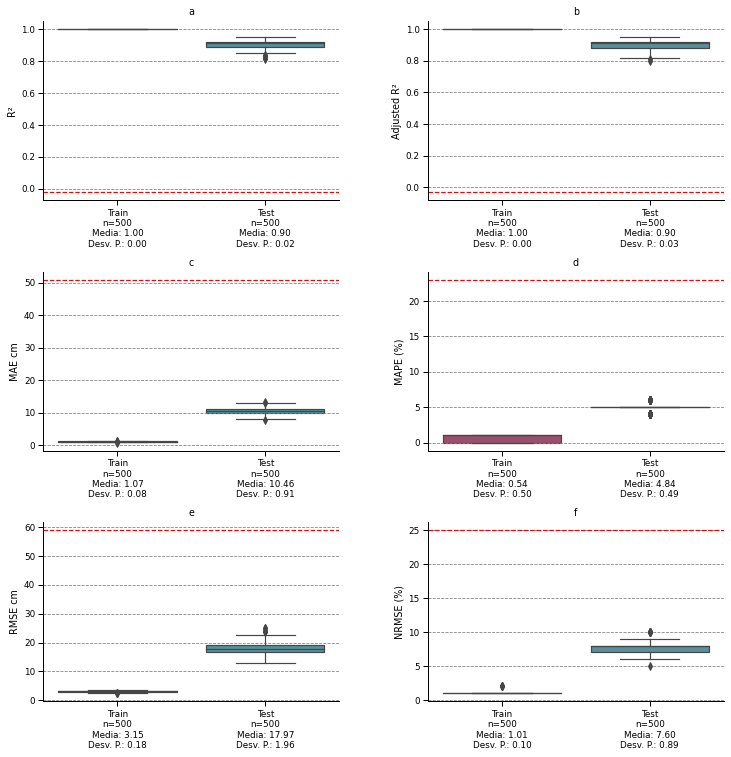


#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#

#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#


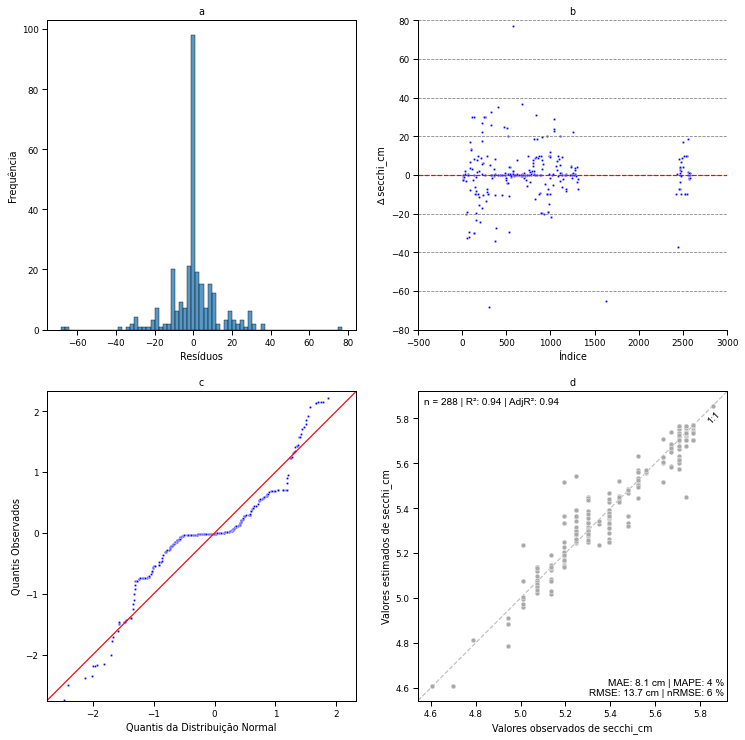

#-----------------------END OF XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)------------------#


In [65]:
X = df_selected[df_selected[s['target']].notna()][s['attributes'].split(", ")] 
y = df_selected[df_selected[s['target']].notna()][s['target']]
rs = s['train_test_rs']
if s['class'] == 'Multivariate':
    mult_v = True
else:
    mult_v = False
wqp_unit = s['target'].split("_")[1]
param_grid = eval(s['params'])
for idx, v in param_grid.items():
    param_grid[idx] = [v]
model = eval(s['model'] + "()")
m_type = s['type']
         
print("#-----------------------MODEL: {}------------------#".format(str(model)))
model_ = Model(X, y, model = model, wqp_unit=wqp_unit, mult_v = mult_v, m_type = m_type, verbose = True)
model_.train_test_split_data(rs=rs)
scoring = model_.scoring_func()
model_.grid_search(param_grid = param_grid, scoring = scoring, n_cv=5, refit = 'RMSE')
t = model_.cv_model_results(n_cv=5, n_repeats=100)
result = model_.model_left_out()
print("#-----------------------END OF {}------------------#".format(str(model)))


### Chla

In [66]:
chl_results = df_results.loc[df_results['target'] == 'chl_rfu']
chl_results.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,type,model,class,attributes,target,params,...,baseline_MAPE (%),mean_train_RMSE,mean_test_RMSE,validation_RMSE,baseline_RMSE,mean_train_NRMSE (%),mean_test_NRMSE (%),validation_NRMSE (%),baseline_NRMSE (%),Unnamed: 0.1.1.1.1
992,0,0,0.0,0.0,linear,Lasso,Univariate,Blue,chl_rfu,{'alpha': 0.1},...,inf,0.37,0.35,0.31,0.36,113.90,107.41,92.0,110.0,NaN
993,1,1,1.0,1.0,linear,Lasso,Univariate,Green,chl_rfu,{'alpha': 0.1},...,inf,0.37,0.35,0.31,0.36,113.90,107.28,92.0,110.0,NaN
994,2,2,2.0,2.0,linear,Lasso,Univariate,Kab 1(Rs),chl_rfu,{'alpha': 0.1},...,inf,0.32,0.29,0.25,0.36,97.25,87.93,72.0,110.0,NaN
995,3,3,3.0,3.0,linear,Lasso,Univariate,B3B1,chl_rfu,{'alpha': 0.1},...,inf,0.37,0.35,0.31,0.36,113.91,107.46,92.0,110.0,NaN
996,4,4,4.0,4.0,linear,Lasso,Univariate,GB1,chl_rfu,{'alpha': 0.1},...,inf,0.36,0.34,0.30,0.36,110.05,102.79,87.0,110.0,NaN


In [67]:
s = chl_results.loc[chl_results['validation_RMSE'].idxmin(), :]
s

Unnamed: 0                                                            234
Unnamed: 0.1                                                          234
Unnamed: 0.1.1                                                      234.0
Unnamed: 0.1.1.1                                                    184.0
type                                                                  log
model                                                        XGBRegressor
class                                                        Multivariate
attributes                              Blue, Green, Kab 1(Rs), B3B1, GB1
target                                                            chl_rfu
params                              {'max_depth': 10, 'n_estimators': 10}
train_test_rs                                                           4
fit/test/validation                                           950/238/298
KFoldRepeat                                         5 folds x 100 repeats
cv_rs                                 

#-----------------------MODEL: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)------------------#

#--------------INICIANDO O GRID SEARCH CV------------#

O GridSearchCV encontrou os melhores hiperparâmetros                     para o modelo escolhido (XGBRegressor(base_score=None, booster=None, callbacks=None,
     

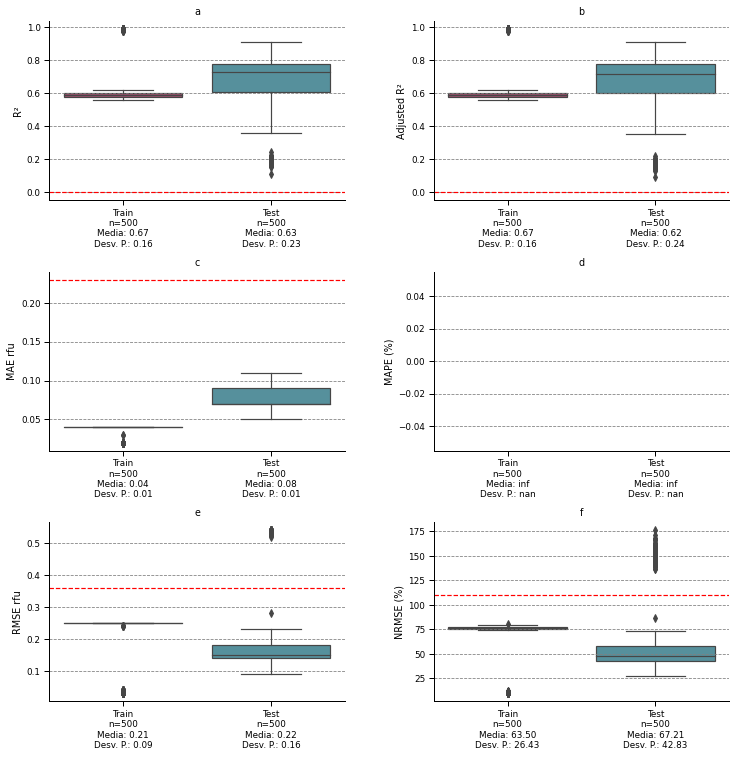


#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#

#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#


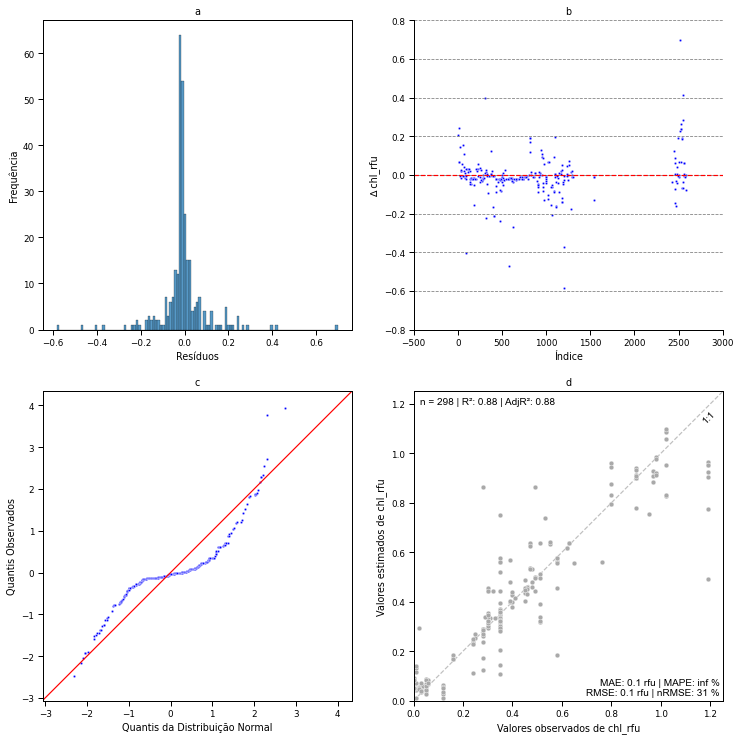

#-----------------------END OF XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)------------------#


In [68]:
X = df_selected[df_selected[s['target']].notna()][s['attributes'].split(", ")] 
y = df_selected[df_selected[s['target']].notna()][s['target']]
rs = s['train_test_rs']
if s['class'] == 'Multivariate':
    mult_v = True
else:
    mult_v = False
wqp_unit = s['target'].split("_")[1]
param_grid = eval(s['params'])
for idx, v in param_grid.items():
    param_grid[idx] = [v]
model = eval(s['model'] + "()")
m_type = s['type']
         
print("#-----------------------MODEL: {}------------------#".format(str(model)))
model_ = Model(X, y, model = model, wqp_unit=wqp_unit, mult_v = mult_v, m_type = m_type, verbose = True)
model_.train_test_split_data(rs=rs)
scoring = model_.scoring_func()
model_.grid_search(param_grid = param_grid, scoring = scoring, n_cv=5, refit = 'RMSE')
t = model_.cv_model_results(n_cv=5, n_repeats=100)
result = model_.model_left_out()
print("#-----------------------END OF {}------------------#".format(str(model)))


### PC

In [8]:
pc_results = df_results.loc[df_results['target'] == 'pc_rfu']
pc_results.head()

NameError: name 'df_results' is not defined

In [70]:
s = pc_results.loc[pc_results['validation_RMSE'].idxmin(), :]
s

Unnamed: 0                                                              347
Unnamed: 0.1                                                            347
Unnamed: 0.1.1                                                        347.0
Unnamed: 0.1.1.1                                                      267.0
type                                                                 linear
model                                                 RandomForestRegressor
class                                                          Multivariate
attributes                Blue, Green, Red, KIVU, Kab 1(Rs), NDCI, 2BDA_...
target                                                               pc_rfu
params                    {'criterion': 'squared_error', 'max_depth': 50...
train_test_rs                                                             4
fit/test/validation                                             950/238/298
KFoldRepeat                                           5 folds x 100 repeats
cv_rs       

#-----------------------MODEL: RandomForestRegressor()------------------#

#--------------INICIANDO O GRID SEARCH CV------------#

O GridSearchCV encontrou os melhores hiperparâmetros                     para o modelo escolhido (RandomForestRegressor()), sendo eles: {'criterion': 'squared_error', 'max_depth': 50, 'n_estimators': 100}

#-----------FIM DO GRID SEARCH CV--------------#

#--------------INICIANDO O CROSS VALIDATION PARA OS MELHORES HYPERPARAMETERS------------#

#-----------PLOTANDO GRÁFICOS COM MÉTRICAS DE TREINAMENTO E TESTE--------------#

#-----------FIM DO CROSS VALIDATION--------------#


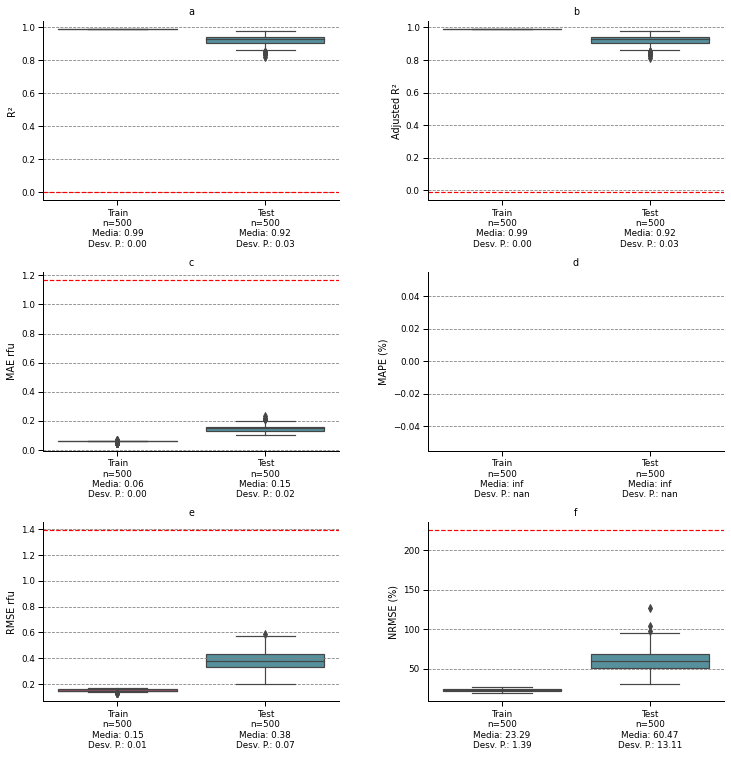


#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#

#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#


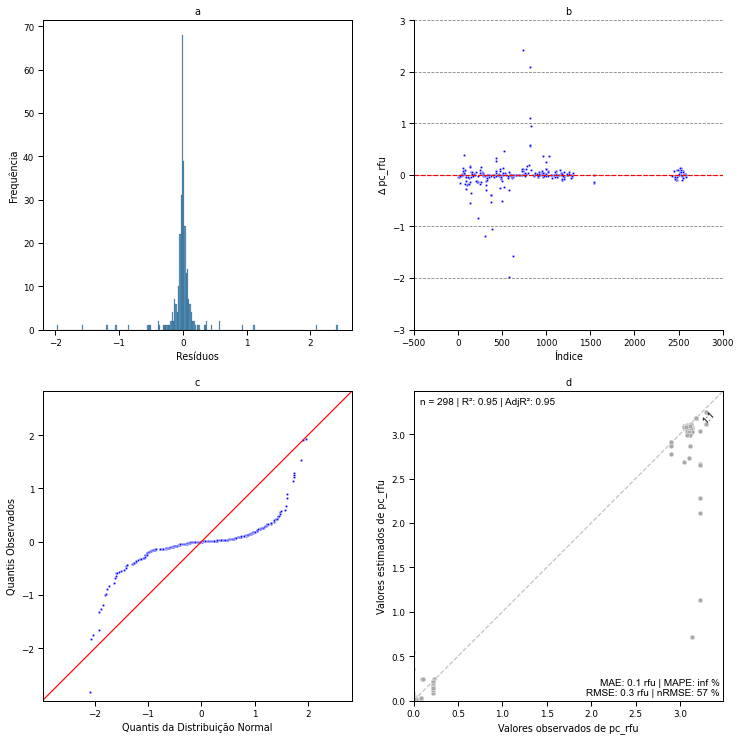

#-----------------------END OF RandomForestRegressor(max_depth=50)------------------#


In [71]:
X = df_selected[df_selected[s['target']].notna()][s['attributes'].split(", ")] 
y = df_selected[df_selected[s['target']].notna()][s['target']]
rs = s['train_test_rs']
if s['class'] == 'Multivariate':
    mult_v = True
else:
    mult_v = False
wqp_unit = s['target'].split("_")[1]
param_grid = eval(s['params'])
for idx, v in param_grid.items():
    param_grid[idx] = [v]
model = eval(s['model'] + "()")
m_type = s['type']
         
print("#-----------------------MODEL: {}------------------#".format(str(model)))
model_ = Model(X, y, model = model, wqp_unit=wqp_unit, mult_v = mult_v, m_type = m_type, verbose = True)
model_.train_test_split_data(rs=rs)
scoring = model_.scoring_func()
model_.grid_search(param_grid = param_grid, scoring = scoring, n_cv=5, refit = 'RMSE')
t = model_.cv_model_results(n_cv=5, n_repeats=100)
result = model_.model_left_out()
print("#-----------------------END OF {}------------------#".format(str(model)))


### FDOM

In [72]:
fdom_results = df_results.loc[df_results['target'] == 'fdom_rfu']
fdom_results.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,type,model,class,attributes,target,params,...,baseline_MAPE (%),mean_train_RMSE,mean_test_RMSE,validation_RMSE,baseline_RMSE,mean_train_NRMSE (%),mean_test_NRMSE (%),validation_NRMSE (%),baseline_NRMSE (%),Unnamed: 0.1.1.1.1
3476,0,0,0.0,0.0,linear,Lasso,Univariate,Blue,fdom_rfu,{'alpha': 0.1},...,33.0,1.05,1.05,1.08,1.06,32.19,32.31,34.0,33.0,NaN
3477,1,1,1.0,1.0,linear,Lasso,Univariate,Green,fdom_rfu,{'alpha': 0.1},...,33.0,1.05,1.05,1.08,1.06,32.18,32.34,34.0,33.0,NaN
3478,2,2,2.0,2.0,linear,Lasso,Univariate,Kab 1(Rs),fdom_rfu,{'alpha': 0.1},...,33.0,0.66,0.66,0.69,1.06,20.18,20.28,22.0,33.0,NaN
3479,3,3,3.0,3.0,linear,Lasso,Univariate,NDCI,fdom_rfu,{'alpha': 0.1},...,33.0,0.78,0.78,0.82,1.06,23.90,24.00,26.0,33.0,NaN
3480,4,4,4.0,4.0,linear,Lasso,Univariate,2BDA_2,fdom_rfu,{'alpha': 0.1},...,33.0,0.80,0.80,0.84,1.06,24.58,24.71,26.0,33.0,NaN


In [73]:
s = fdom_results.loc[fdom_results['validation_RMSE'].idxmin(), :]
s

Unnamed: 0                                                              445
Unnamed: 0.1                                                            445
Unnamed: 0.1.1                                                        445.0
Unnamed: 0.1.1.1                                                      364.0
type                                                                min_max
model                                                 RandomForestRegressor
class                                                          Multivariate
attributes                  Blue, Green, Kab 1(Rs), NDCI, 2BDA_2, B3B1, GB1
target                                                             fdom_rfu
params                    {'criterion': 'squared_error', 'max_depth': 25...
train_test_rs                                                             4
fit/test/validation                                             505/127/159
KFoldRepeat                                           5 folds x 100 repeats
cv_rs       

#-----------------------MODEL: RandomForestRegressor()------------------#

#--------------INICIANDO O GRID SEARCH CV------------#

O GridSearchCV encontrou os melhores hiperparâmetros                     para o modelo escolhido (RandomForestRegressor()), sendo eles: {'criterion': 'squared_error', 'max_depth': 25, 'n_estimators': 50}

#-----------FIM DO GRID SEARCH CV--------------#

#--------------INICIANDO O CROSS VALIDATION PARA OS MELHORES HYPERPARAMETERS------------#

#-----------PLOTANDO GRÁFICOS COM MÉTRICAS DE TREINAMENTO E TESTE--------------#

#-----------FIM DO CROSS VALIDATION--------------#


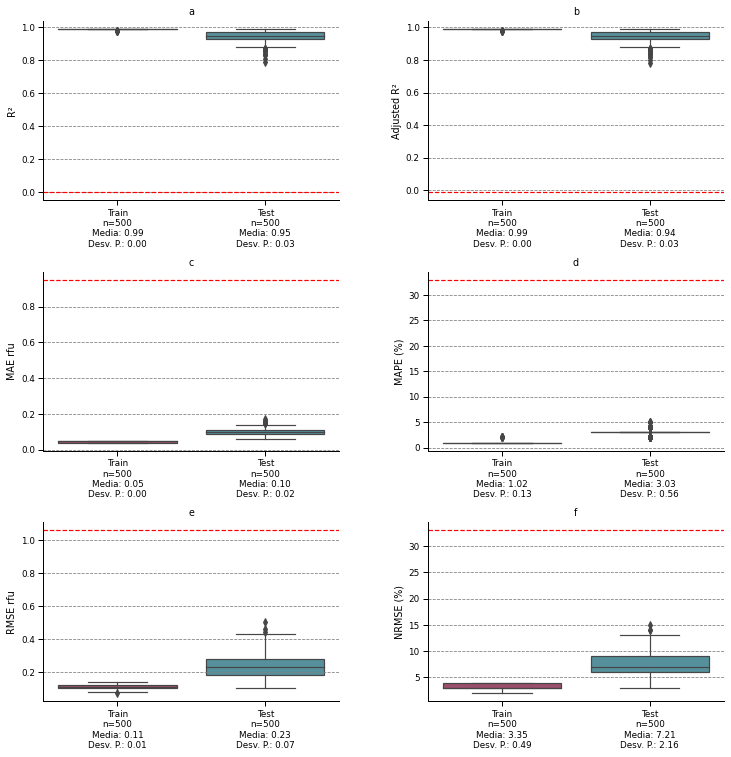


#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#

#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#


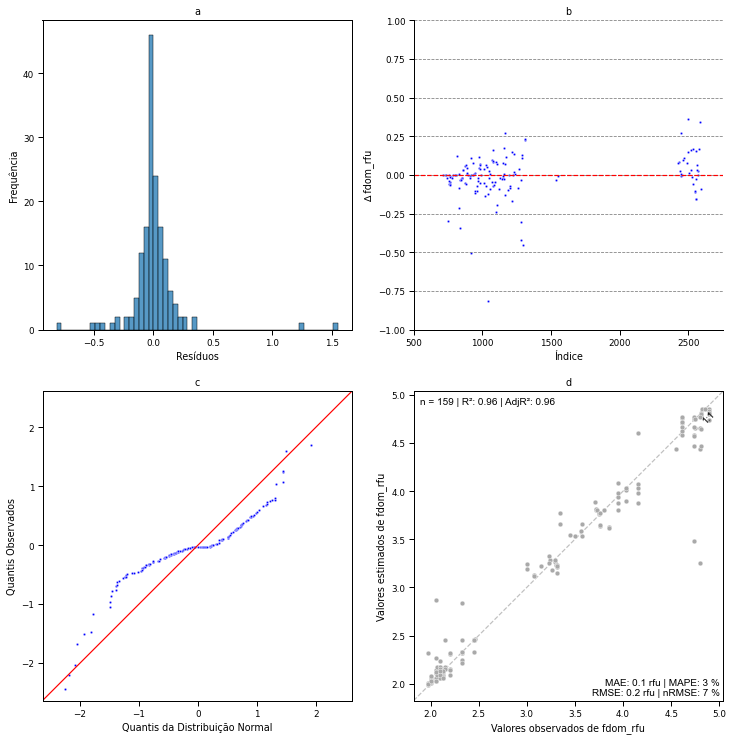

#-----------------------END OF RandomForestRegressor(max_depth=25, n_estimators=50)------------------#


In [74]:
X = df_selected[df_selected[s['target']].notna()][s['attributes'].split(", ")] 
y = df_selected[df_selected[s['target']].notna()][s['target']]
rs = s['train_test_rs']
if s['class'] == 'Multivariate':
    mult_v = True
else:
    mult_v = False
wqp_unit = s['target'].split("_")[1]
param_grid = eval(s['params'])
for idx, v in param_grid.items():
    param_grid[idx] = [v]
model = eval(s['model'] + "()")
m_type = s['type']
         
print("#-----------------------MODEL: {}------------------#".format(str(model)))
model_ = Model(X, y, model = model, wqp_unit=wqp_unit, mult_v = mult_v, m_type = m_type, verbose = True)
model_.train_test_split_data(rs=rs)
scoring = model_.scoring_func()
model_.grid_search(param_grid = param_grid, scoring = scoring, n_cv=5, refit = 'RMSE')
t = model_.cv_model_results(n_cv=5, n_repeats=100)
result = model_.model_left_out()
print("#-----------------------END OF {}------------------#".format(str(model)))


### Turbidez

In [75]:
turb_results = df_results.loc[df_results['target'] == 'turb_fnu']
turb_results.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,type,model,class,attributes,target,params,...,baseline_MAPE (%),mean_train_RMSE,mean_test_RMSE,validation_RMSE,baseline_RMSE,mean_train_NRMSE (%),mean_test_NRMSE (%),validation_NRMSE (%),baseline_NRMSE (%),Unnamed: 0.1.1.1.1
5368,0,0,0.0,0.0,linear,Lasso,Univariate,Blue,turb_fnu,{'alpha': 0.1},...,30.0,0.77,0.77,0.85,0.79,44.13,43.96,47.0,45.0,NaN
5369,1,1,1.0,1.0,linear,Lasso,Univariate,Green,turb_fnu,{'alpha': 0.1},...,30.0,0.77,0.77,0.85,0.79,44.15,43.93,47.0,45.0,NaN
5370,2,2,2.0,2.0,linear,Lasso,Univariate,Red,turb_fnu,{'alpha': 0.1},...,30.0,0.77,0.77,0.85,0.79,44.15,43.99,47.0,45.0,NaN
5371,3,3,3.0,3.0,linear,Lasso,Univariate,B3B1,turb_fnu,{'alpha': 0.1},...,30.0,0.77,0.77,0.85,0.79,44.15,43.95,47.0,45.0,NaN
5372,4,4,4.0,4.0,linear,Lasso,Univariate,GB1,turb_fnu,{'alpha': 0.1},...,30.0,0.69,0.69,0.77,0.79,39.61,39.45,42.0,45.0,NaN


In [76]:
s = turb_results.loc[turb_results['validation_RMSE'].idxmin(), :]
s

Unnamed: 0                                                              513
Unnamed: 0.1                                                            513
Unnamed: 0.1.1                                                        513.0
Unnamed: 0.1.1.1                                                      446.0
type                                                        standard_scaler
model                                                 RandomForestRegressor
class                                                          Multivariate
attributes                                      Blue, Green, Red, B3B1, GB1
target                                                             turb_fnu
params                    {'criterion': 'squared_error', 'max_depth': 50...
train_test_rs                                                             4
fit/test/validation                                             950/238/298
KFoldRepeat                                           5 folds x 100 repeats
cv_rs       

#-----------------------MODEL: RandomForestRegressor()------------------#

#--------------INICIANDO O GRID SEARCH CV------------#

O GridSearchCV encontrou os melhores hiperparâmetros                     para o modelo escolhido (RandomForestRegressor()), sendo eles: {'criterion': 'squared_error', 'max_depth': 50, 'n_estimators': 1000}

#-----------FIM DO GRID SEARCH CV--------------#

#--------------INICIANDO O CROSS VALIDATION PARA OS MELHORES HYPERPARAMETERS------------#

#-----------PLOTANDO GRÁFICOS COM MÉTRICAS DE TREINAMENTO E TESTE--------------#

#-----------FIM DO CROSS VALIDATION--------------#


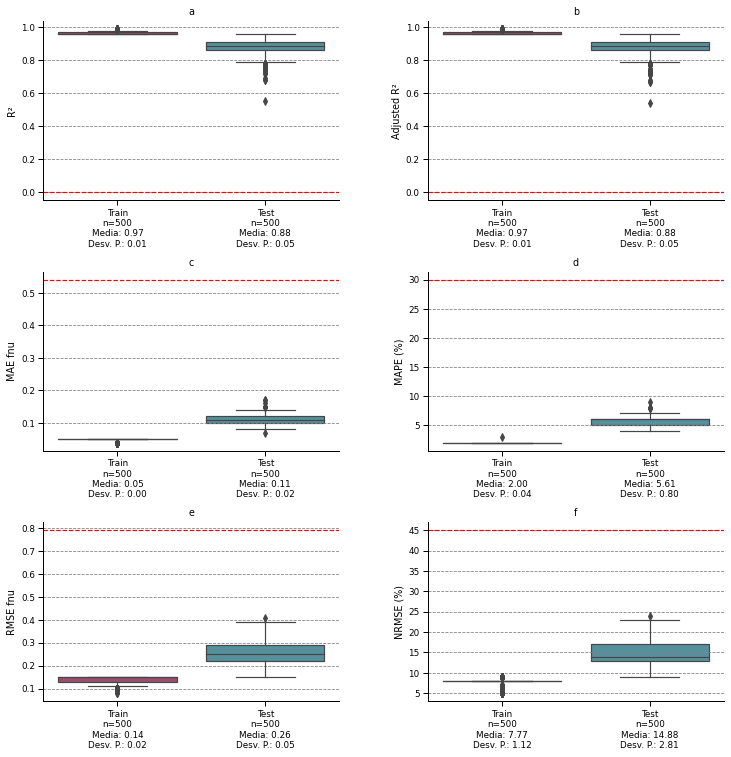


#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#

#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#


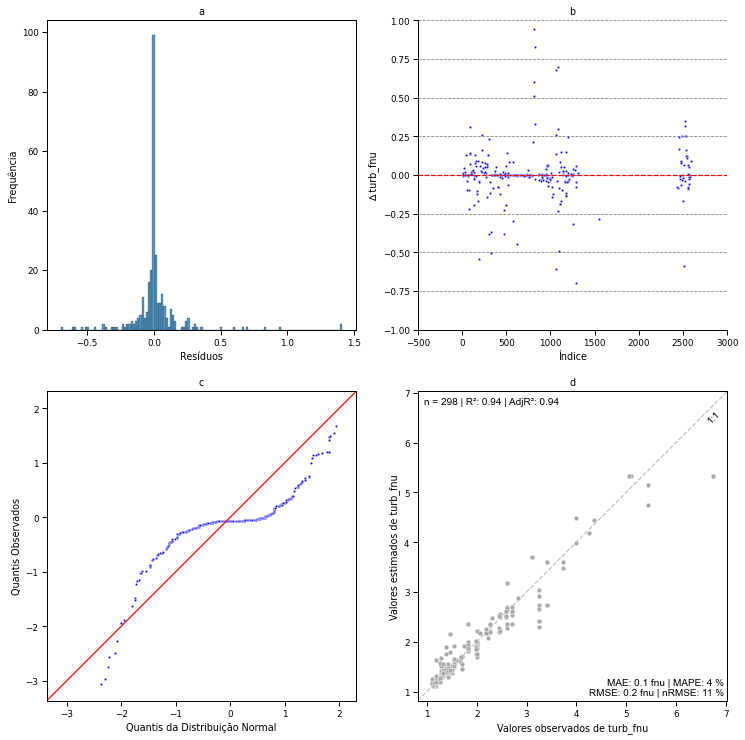

#-----------------------END OF RandomForestRegressor(max_depth=50, n_estimators=1000)------------------#


In [77]:
X = df_selected[df_selected[s['target']].notna()][s['attributes'].split(", ")] 
y = df_selected[df_selected[s['target']].notna()][s['target']]
rs = s['train_test_rs']
if s['class'] == 'Multivariate':
    mult_v = True
else:
    mult_v = False
wqp_unit = s['target'].split("_")[1]
param_grid = eval(s['params'])
for idx, v in param_grid.items():
    param_grid[idx] = [v]
model = eval(s['model'] + "()")
m_type = s['type']
         
print("#-----------------------MODEL: {}------------------#".format(str(model)))
model_ = Model(X, y, model = model, wqp_unit=wqp_unit, mult_v = mult_v, m_type = m_type, verbose = True)
model_.train_test_split_data(rs=rs)
scoring = model_.scoring_func()
model_.grid_search(param_grid = param_grid, scoring = scoring, n_cv=5, refit = 'RMSE')
t = model_.cv_model_results(n_cv=5, n_repeats=100)
result = model_.model_left_out()
print("#-----------------------END OF {}------------------#".format(str(model)))
